RMSE: 0.102
R²:   0.435


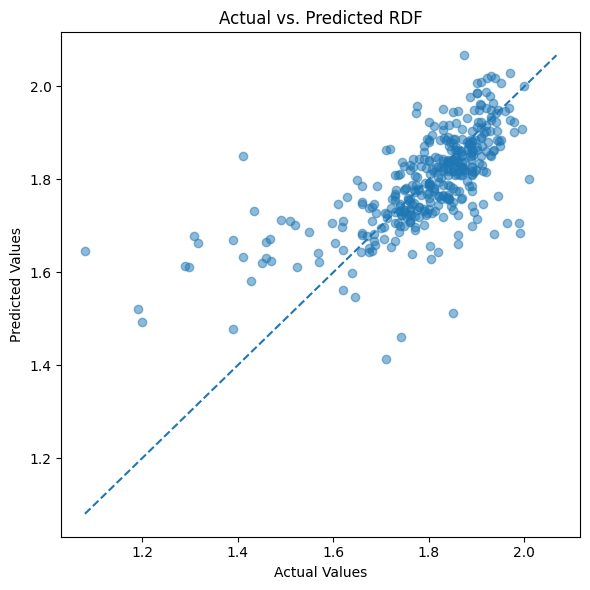

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv('data/combined_feature.csv')
X = df.iloc[:, 9:]
y = df['RDF Peak']

initial_drop = ['max_length', 'min_block_size']
X = X.drop(columns=initial_drop)

corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
target_corr = X.join(y).corr()[y.name].abs()
multi_drop = {
    i if target_corr[i] < target_corr[j] else j
    for i in upper.index
    for j in upper.columns
    if upper.loc[i, j] > 0.90
}
X = X.drop(columns=multi_drop)

drop_cols = initial_drop + list(multi_drop)
orig_log = ['max_fft_value', 'mayo_lewis']
orig_cube = ['harwoods_blockiness']
orig_square = ['sum_fft_value']
orig_yj1 = ['mean_block_size', 'std_block_size']
orig_yj2 = ['min_charge', 'max_charge']

log_cols = [c for c in orig_log if c in X.columns]
cube_cols = [c for c in orig_cube if c in X.columns]
square_cols = [c for c in orig_square if c in X.columns]
yeoj_cols_size = [c for c in orig_yj1 if c in X.columns]
yeoj_cols_charge = [c for c in orig_yj2 if c in X.columns]
other_cols = X.columns.difference(
    drop_cols + log_cols + cube_cols + square_cols +
    yeoj_cols_size + yeoj_cols_charge
)

def shifted_log1p(a):
    shift = (-np.minimum(0, a.min(axis=0))) + 1
    return np.log1p(a + shift)

transformers = []
if log_cols:
    transformers.append(('log', FunctionTransformer(shifted_log1p, feature_names_out='one-to-one'), log_cols))
if cube_cols:
    transformers.append(('cube', FunctionTransformer(np.cbrt, feature_names_out='one-to-one'), cube_cols))
if square_cols:
    transformers.append(('square', FunctionTransformer(np.square, feature_names_out='one-to-one'), square_cols))
if yeoj_cols_size:
    transformers.append(('yj1', PowerTransformer(method='yeo-johnson', standardize=False), yeoj_cols_size))
if yeoj_cols_charge:
    transformers.append(('yj2', PowerTransformer(method='yeo-johnson', standardize=False), yeoj_cols_charge))
transformers.append(('pass', 'passthrough', other_cols))

preprocessor = ColumnTransformer(transformers, remainder='drop', verbose_feature_names_out=False)

model = Pipeline([
    ('prep', preprocessor),
    ('scale', StandardScaler()),
    ('lr', LinearRegression())
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(model, X, y, cv=cv)

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5)
lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted RDF')
plt.tight_layout()
plt.savefig('plots/rdf.png', dpi=300)
plt.show()

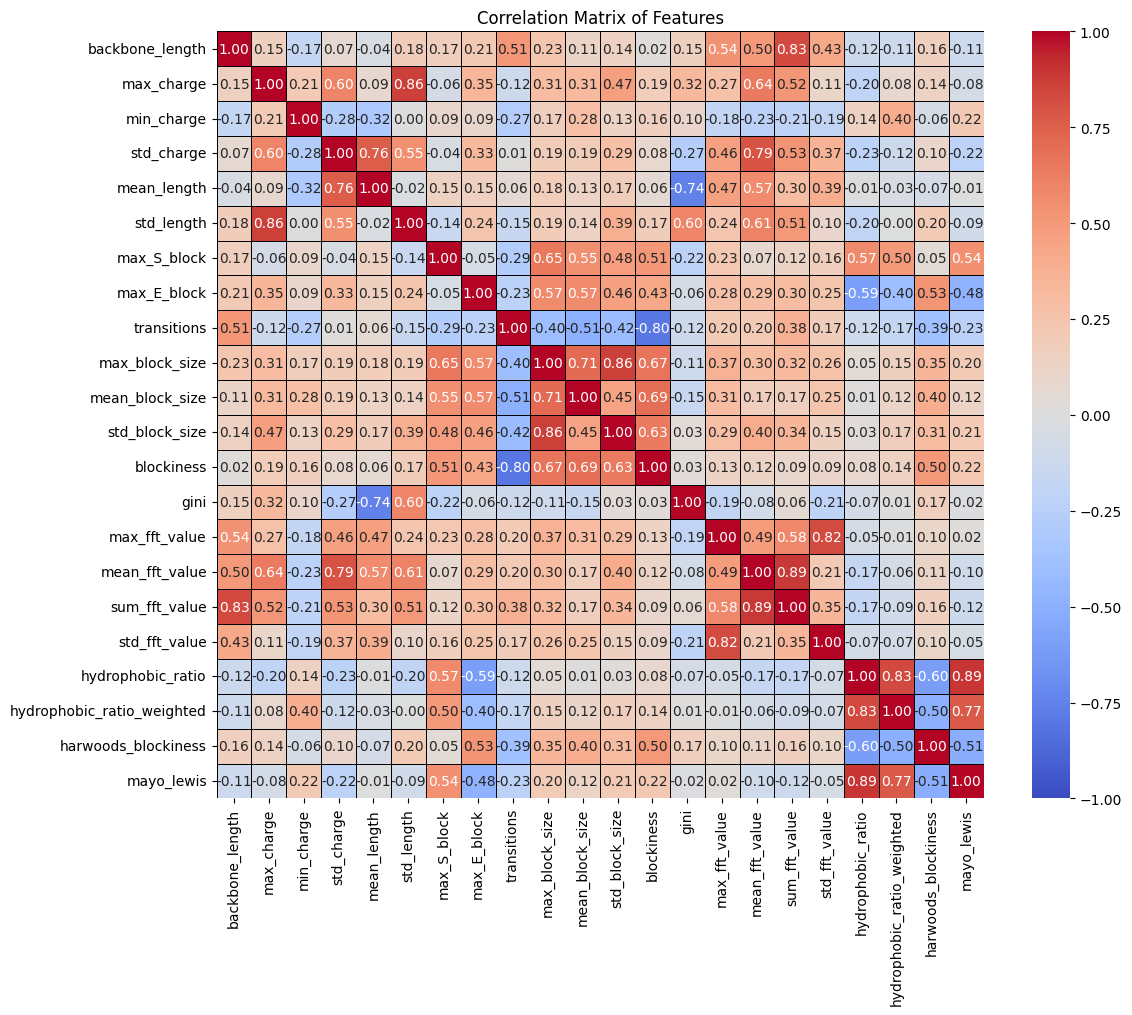

In [102]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    X.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    linecolor="black"
)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.savefig('plots/rdfFF.png', dpi=300)
plt.show()

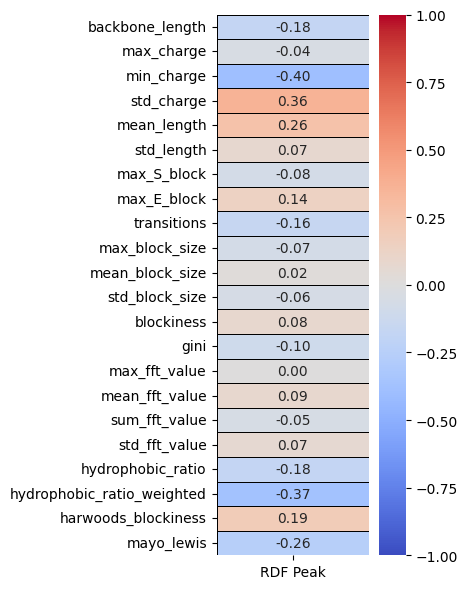

In [103]:
pearson_corr = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(4.5, 6))
sns.heatmap(
    pearson_corr.loc[X.columns, [y.name]],
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor="black"
)
plt.tight_layout()
plt.savefig('plots/rdfFT', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()